<a href="https://colab.research.google.com/github/Krishnakanth1993/Learnings/blob/main/MNIST_Model/Reference/minimal_prameter_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [43]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [44]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=1024, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [45]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([1024, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([1024])


# **Data Loading & Preprocessing**

In [46]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [47]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [50]:
batch_size = 1024

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

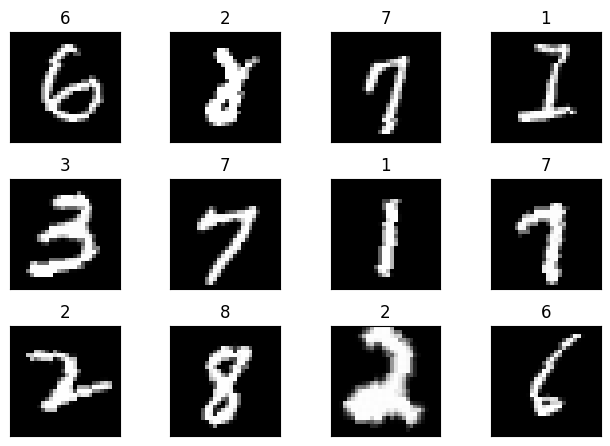

In [51]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [58]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, padding=1) #28x28x1  | (3x3x1)32 | 28x28x32 RF 3x3
        self.bn1 = nn.BatchNorm2d(28)
        self.conv2 = nn.Conv2d(28, 28, kernel_size=3, padding=1) #28x28x32 | (3x3x32)x32 | 28x28x32 RF 5x5
        self.bn2 = nn.BatchNorm2d(28)
        self.conv3 = nn.Conv2d(28, 16, kernel_size=3, padding=1) #14x14x32 | (3x3x32)x16 | 14x14x16 RF 10x10
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1) #14x14x16  | (3x3x16)16 | 14x14x16 RF 12x12
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 8, kernel_size=3, padding=1) #7x7x16  | (3x3x16)x8 | 7x7x8 RF 24x24
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 8, kernel_size=3, padding=1) #7x7x8 | (3x3x8)x8 | 7x7x8 RF 26x26
        self.bn6 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 7 * 7, 10) #RF 26x26

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn5(self.conv5(x))
        x = F.relu(x)
        x = self.bn6(self.conv6(x))
        x = F.relu(x)
        x = x.view(-1, 8 * 7 * 7)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Training Setup

In [53]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [54]:
# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Shape: [batch_size]
            test_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)  # Average per sample
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [59]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.2292 Batch_id=58 Accuracy=81.70: 100%|██████████| 59/59 [00:19<00:00,  3.08it/s]


Test set: Average loss: 0.2067, Accuracy: 9582/10000 (95.82%)

Epoch 2


Train: Loss=0.1268 Batch_id=58 Accuracy=96.23: 100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


Test set: Average loss: 0.0880, Accuracy: 9782/10000 (97.82%)

Epoch 3


Train: Loss=0.0842 Batch_id=58 Accuracy=97.41: 100%|██████████| 59/59 [00:18<00:00,  3.16it/s]


Test set: Average loss: 0.0537, Accuracy: 9847/10000 (98.47%)

Epoch 4


Train: Loss=0.0715 Batch_id=58 Accuracy=97.86: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


Test set: Average loss: 0.0483, Accuracy: 9868/10000 (98.68%)

Epoch 5


Train: Loss=0.0622 Batch_id=58 Accuracy=98.13: 100%|██████████| 59/59 [00:17<00:00,  3.30it/s]


Test set: Average loss: 0.0418, Accuracy: 9881/10000 (98.81%)

Epoch 6


Train: Loss=0.0589 Batch_id=58 Accuracy=98.41: 100%|██████████| 59/59 [00:18<00:00,  3.20it/s]


Test set: Average loss: 0.0369, Accuracy: 9895/10000 (98.95%)

Epoch 7


Train: Loss=0.0726 Batch_id=58 Accuracy=98.41: 100%|██████████| 59/59 [00:18<00:00,  3.27it/s]


Test set: Average loss: 0.0324, Accuracy: 9899/10000 (98.99%)

Epoch 8


Train: Loss=0.0322 Batch_id=58 Accuracy=98.58: 100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


Test set: Average loss: 0.0305, Accuracy: 9912/10000 (99.12%)

Epoch 9


Train: Loss=0.0355 Batch_id=58 Accuracy=98.67: 100%|██████████| 59/59 [00:18<00:00,  3.14it/s]


Test set: Average loss: 0.0284, Accuracy: 9910/10000 (99.10%)

Epoch 10


Train: Loss=0.0627 Batch_id=58 Accuracy=98.73: 100%|██████████| 59/59 [00:17<00:00,  3.33it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

Epoch 11


Train: Loss=0.0227 Batch_id=58 Accuracy=98.98: 100%|██████████| 59/59 [00:19<00:00,  2.97it/s]


Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

Epoch 12


Train: Loss=0.0426 Batch_id=58 Accuracy=98.91: 100%|██████████| 59/59 [00:18<00:00,  3.22it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

Epoch 13


Train: Loss=0.0330 Batch_id=58 Accuracy=99.00: 100%|██████████| 59/59 [00:17<00:00,  3.29it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

Epoch 14


Train: Loss=0.0324 Batch_id=58 Accuracy=99.01: 100%|██████████| 59/59 [00:19<00:00,  3.02it/s]


Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.24%)

Epoch 15


Train: Loss=0.0450 Batch_id=58 Accuracy=98.99: 100%|██████████| 59/59 [00:17<00:00,  3.31it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

Epoch 16


Train: Loss=0.0267 Batch_id=58 Accuracy=99.02: 100%|██████████| 59/59 [00:18<00:00,  3.25it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

Epoch 17


Train: Loss=0.0212 Batch_id=58 Accuracy=99.04: 100%|██████████| 59/59 [00:18<00:00,  3.18it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

Epoch 18


Train: Loss=0.0506 Batch_id=58 Accuracy=99.04: 100%|██████████| 59/59 [00:17<00:00,  3.41it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

Epoch 19


Train: Loss=0.0224 Batch_id=58 Accuracy=99.03: 100%|██████████| 59/59 [00:18<00:00,  3.25it/s]


Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.25%)

Epoch 20


Train: Loss=0.0435 Batch_id=58 Accuracy=99.09: 100%|██████████| 59/59 [00:18<00:00,  3.23it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)



# Test Results

Text(0.5, 1.0, 'Test Accuracy')

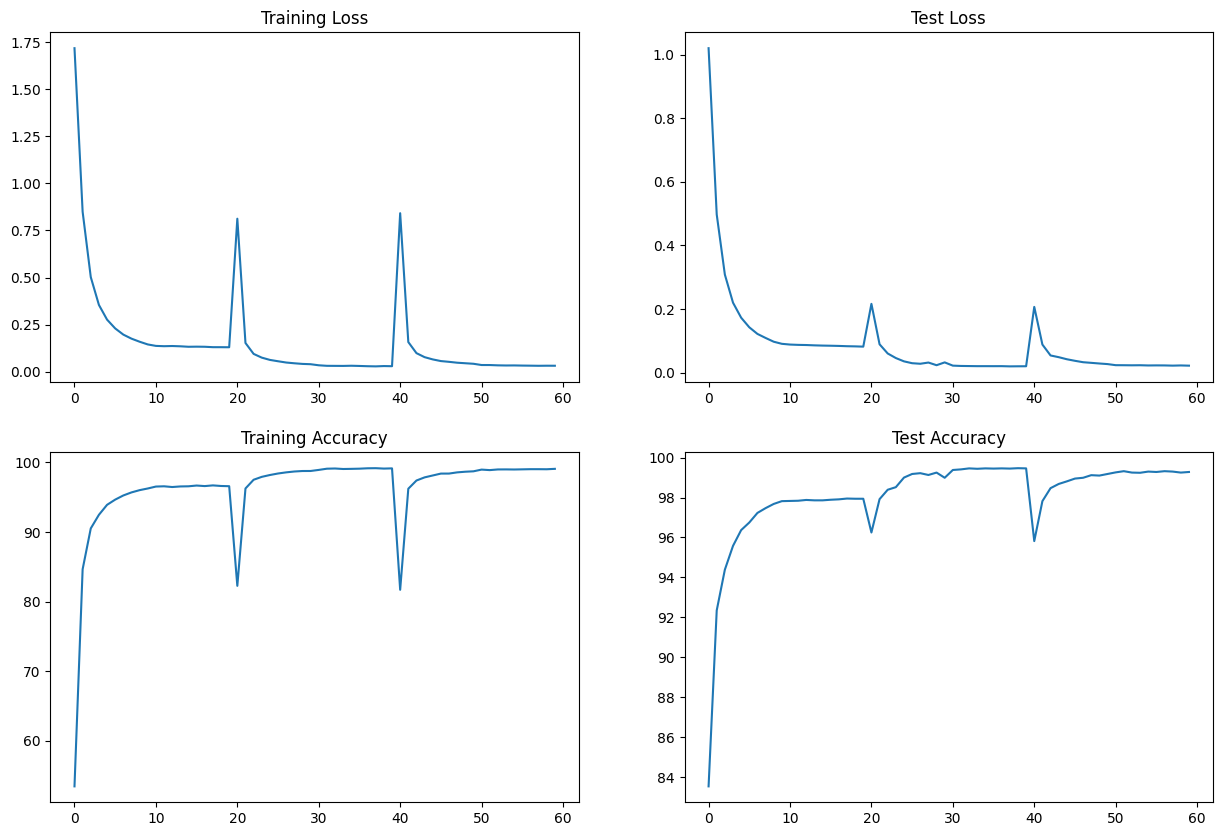

In [61]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [60]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             280
       BatchNorm2d-2           [-1, 28, 28, 28]              56
            Conv2d-3           [-1, 28, 28, 28]           7,084
       BatchNorm2d-4           [-1, 28, 28, 28]              56
            Conv2d-5           [-1, 16, 14, 14]           4,048
       BatchNorm2d-6           [-1, 16, 14, 14]              32
            Conv2d-7           [-1, 16, 14, 14]           2,320
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9              [-1, 8, 7, 7]           1,160
      BatchNorm2d-10              [-1, 8, 7, 7]              16
           Conv2d-11              [-1, 8, 7, 7]             584
      BatchNorm2d-12              [-1, 8, 7, 7]              16
           Linear-13                   [-1, 10]           3,930
Total params: 19,614
Trainable params: 

# Save and Visualize Model

In [ ]:
torch.save(model, "model.pt") ## does not include details of activation functions

In [ ]:
!pip install onnx
device = torch.device("cuda" if use_cuda else "cpu")

# Create dummy input with the same shape as your input
dummy_input = torch.randn(1, 1, 28, 28).to(device)  # Batch x Channels x Height x Width

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

/tmp/ipython-input-3254252982.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "model.onnx",


In [62]:
model

Net(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(28, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.4 MB/s eta 0:00:00
